In [225]:
import random
import csv
from random import randint
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt

In [226]:
series_id_list = [
    "Spänning L1",
    "Spänning L2",
    "Spänning L3",
    "P14 L1",
    "P14 L2",
    "P14 L3",
    "P23 L1",
    "P23 L2",
    "P23 L3",
    "A14",
    "A23",
    "Q12 L1",
    "Q12 L2",
    "Q12 L3",
    "Q34 L1",
    "Q34 L2",
    "Q34 L3",
    "R12",
    "R34",
]
fieldnames = [
    "series_id",
    "location_id",
    "meter_id",
    "time",
    "value",
    "value_status",
    "insert_time",
    "extract_time",
]

In [227]:
# [(location id,meter id)]
unique_lid_mid = [
    (
        "".join(["{}".format(random.randint(0, 9)) for _ in range(18)]),
        "".join(["{}".format(random.randint(0, 9)) for _ in range(16)]),
    )
    for _ in range(10)
]

In [228]:
def generate_event_good(time):
    for lid, mid in unique_lid_mid:
        for x in series_id_list:

            yield {
                "series_id": x,
                "location_id": lid,
                "meter_id": mid,
                "time": time,
                "value": round(random.uniform(235, 240), 2),
                "value_status": "Correct",
                "insert_time": time,
                "extract_time": time,
            }

In [229]:
def generate_event_low(time):
    for lid, mid in unique_lid_mid:
        for x in series_id_list:

            yield {
                "series_id": x,
                "location_id": lid,
                "meter_id": mid,
                "time": time,
                "value": round(random.uniform(230, 235), 2),
                "value_status": "Correct",
                "insert_time": time,
                "extract_time": time,
            }

In [230]:
def generate_event_high(time):
    for lid, mid in unique_lid_mid:
        for x in series_id_list:

            yield {
                "series_id": x,
                "location_id": lid,
                "meter_id": mid,
                "time": time,
                "value": round(random.uniform(240, 245), 2),
                "value_status": "Correct",
                "insert_time": time,
                "extract_time": time,
            }

In [231]:
# total iteration that will run
# in total 19 * 10 * total_event (19 series id, 10 meter-location ids)
total_event = 10000

# start deviation after 100 iteration
deviation_start = 1000
# there will be deviation_time times a deviation will occur
deviation_time = 10
# the deviation duration in iteration
deviation_duration_count = 500
# offset so that two deviation iteration are not side by side
offset = 0

possible_values = list(
    range(
        deviation_start,
        total_event - deviation_duration_count,
        deviation_duration_count + offset,
    )
)
print(possible_values)
# deviation iteration value on when to trigger a deviation
deviation_points = sorted(random.sample(possible_values, deviation_time))
print(deviation_points)

[1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000]
[1000, 1500, 2000, 3000, 4500, 5000, 6000, 6500, 7500, 9000]


In [232]:
# file
file_path = "data/generated_event.csv"

In [233]:
def generate_readings(start_time, total_event):
    current_time = start_time

    with open(file_path, mode="w", newline="") as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        dev_count = 0
        is_high = False
        is_low = False

        for itr in range(total_event):

            if itr in deviation_points:
                if random.choice((True, False)):
                    is_high = True
                else:
                    is_low = True

            if is_low:
                event_gen = generate_event_low(
                    current_time.strftime("%Y-%m-%d %H:%M:%S")
                )
                dev_count += 1
                if dev_count == deviation_duration_count:
                    is_low = False
                    dev_count = 0

            if is_high:
                event_gen = generate_event_high(
                    current_time.strftime("%Y-%m-%d %H:%M:%S")
                )
                dev_count += 1
                if dev_count == deviation_duration_count:
                    is_high = False
                    dev_count = 0

            if not is_low and not is_high:
                event_gen = generate_event_good(
                    current_time.strftime("%Y-%m-%d %H:%M:%S")
                )

            for _ in range((len(series_id_list) * len(unique_lid_mid))):
                event = next(event_gen)
                writer.writerow(event)

            current_time += timedelta(minutes=15)

In [234]:
# User-defined start time
start_time_str = "2024-01-15 08:00:00"
start_time = datetime.strptime(start_time_str, "%Y-%m-%d %H:%M:%S")

# Generate readings
generate_readings(start_time, total_event)

In [235]:
# filter
selected_series_id = "Spänning L1"

In [236]:
def plot(selected_series_id, selected_location_id):
    chunk_size = 10000
    time_data, value_data = [], []

    for chunk in pd.read_csv(file_path, chunksize=chunk_size, parse_dates=["time"]):
        filtered_chunk = chunk[
            (selected_series_id == chunk["series_id"])
            & (selected_location_id == chunk["location_id"])
        ]

        time_data.extend(filtered_chunk["time"])
        value_data.extend(filtered_chunk["value"])

    # Plot the data
    plt.figure(figsize=(12, 6))
    plt.plot(
        time_data,
        value_data,
        marker="o",
        linestyle="-",
        markersize=3,
        color="b",
        alpha=0.7,
    )

    # Formatting the plot
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(
        f"Plot of 'Value' Over 'Time' (Series ID: {selected_series_id}, Location ID: {selected_location_id})"
    )
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

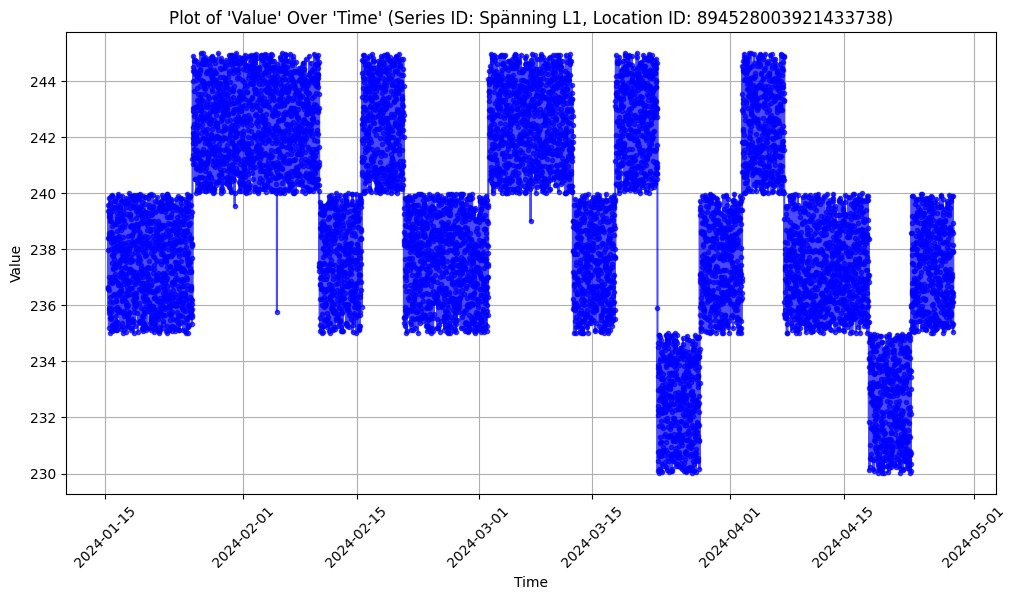

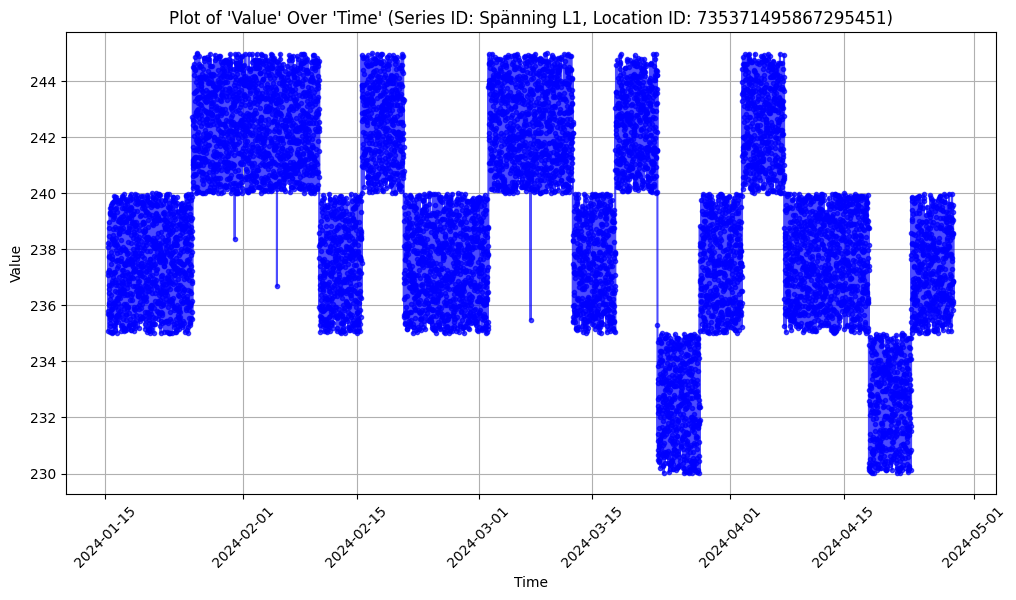

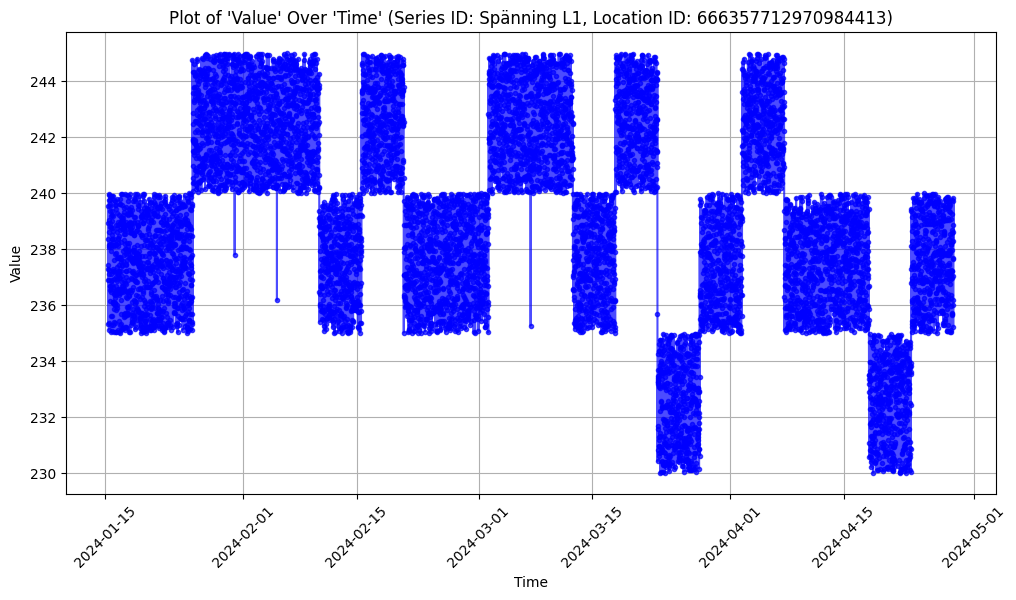

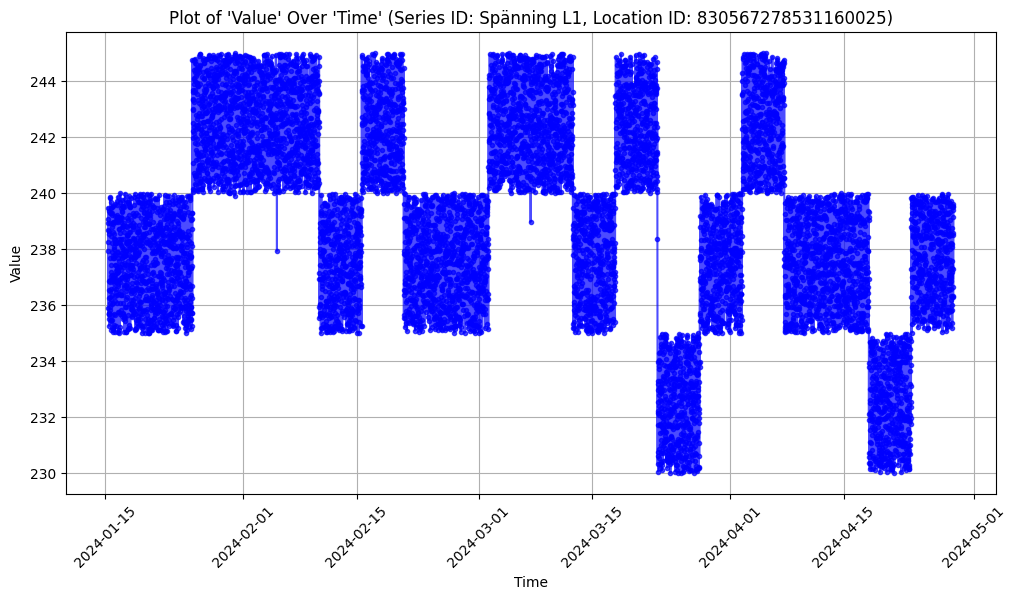

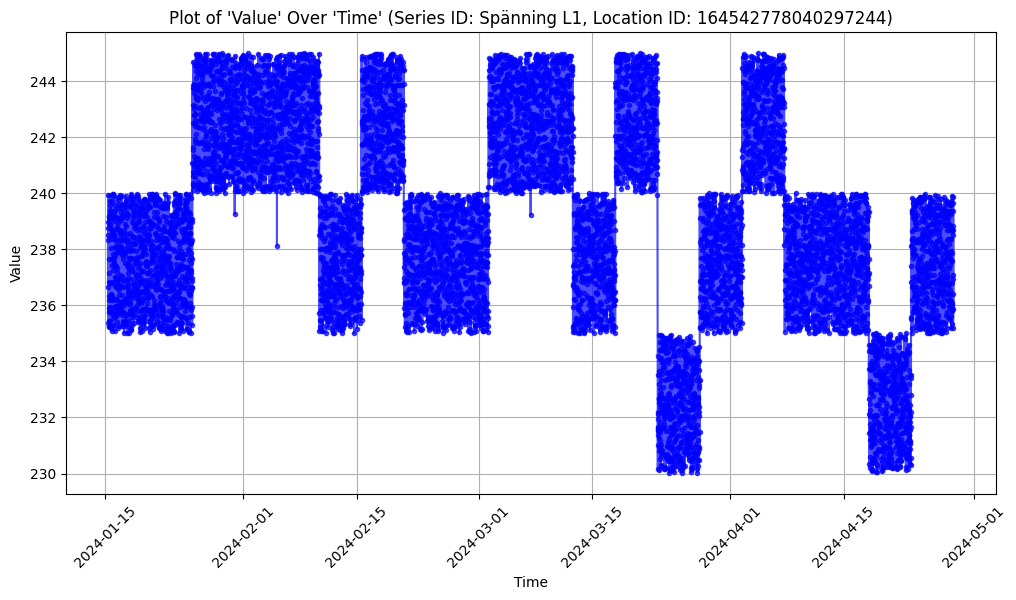

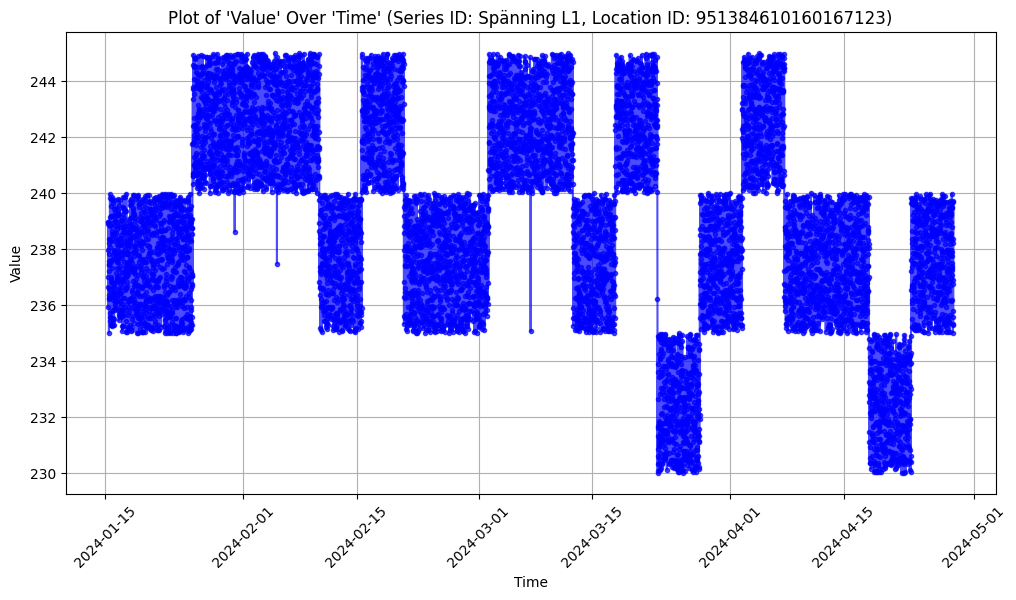

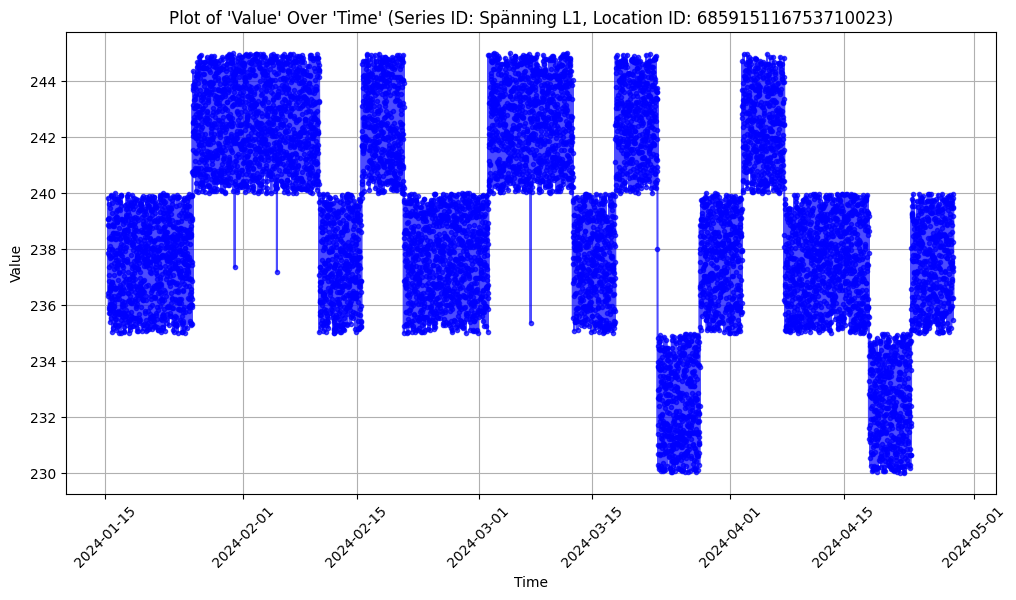

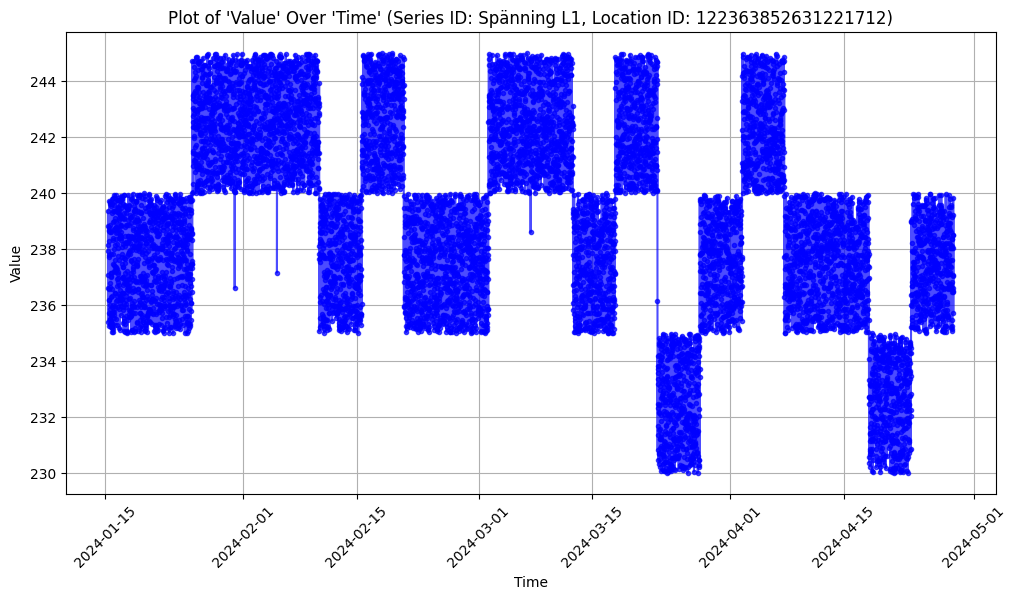

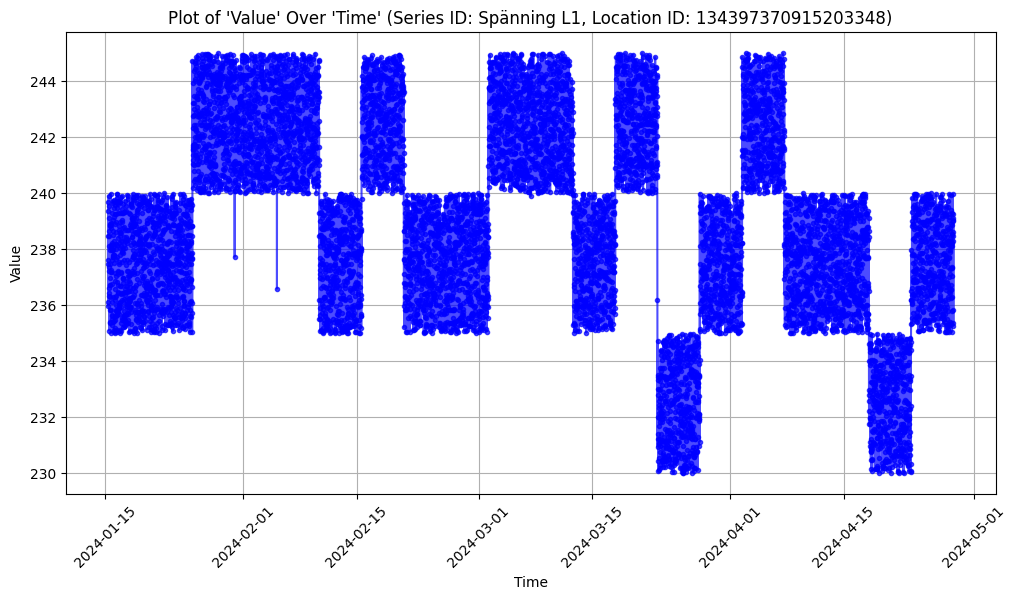

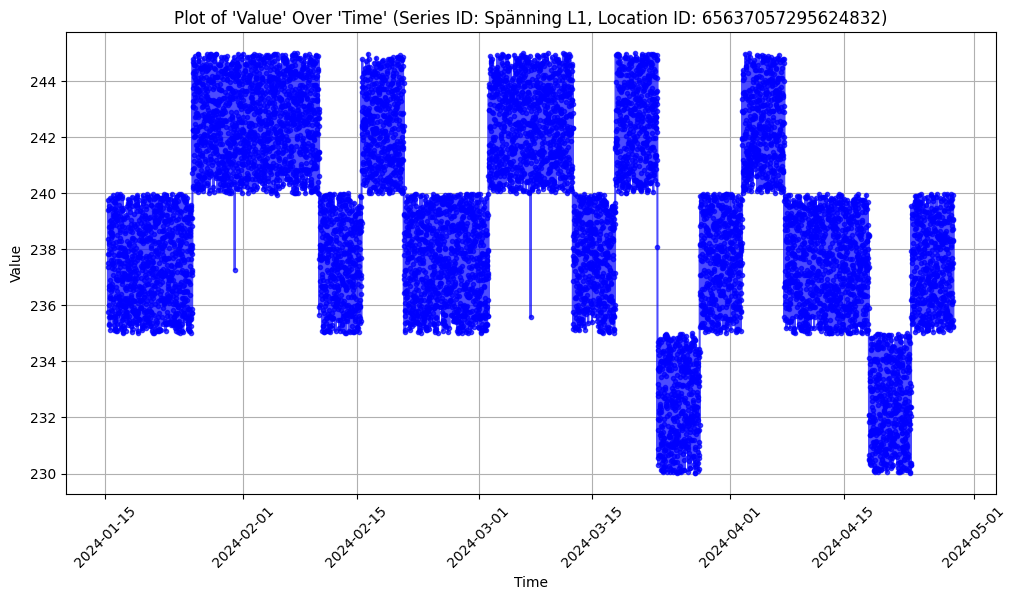

In [237]:
for loc, met in unique_lid_mid:
    plot(selected_series_id, int(loc))